# 🤖 Model: Predict Match Winner (Rank-Only)

In this notebook, we'll build a baseline classification model to predict whether **Player A** wins the match using only **ranking-based features**. 
Our goals:
- Train on 2020–2022, validate on 2023
- Evaluate accuracy and calibration
- Establish a baseline to improve upon later with more features

## 📥 Load Feature Data

We'll start by loading the rank-only feature dataset we created earlier. Each row represents one ATP match restructured as Player A vs Player B.

Our only input feature for now is `rank_diff`, the difference in ATP ranking between the two players.
The target variable is `player_A_won` (1 if Player A won, 0 otherwise).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load rank-only feature set
df = pd.read_csv("../../data/processed/features_rank_match_winner_rank_only.csv")
df.head()


,tourney_date,year,player_A_name,player_B_name,player_A_rank,player_B_rank,player_A_won,rank_diff
0,20200106,2020,Novak Djokovic,Rafael Nadal,2,1,1,-1
1,20200106,2020,Dusan Lajovic,Roberto Bautista Agut,34,10,0,-24
2,20200106,2020,Daniil Medvedev,Novak Djokovic,5,2,0,-3
3,20200106,2020,Karen Khachanov,Dusan Lajovic,17,34,0,17
4,20200106,2020,Rafael Nadal,Alex De Minaur,1,18,1,17



 ## 🧪 Split Data: Train (2020–2022) vs Validation (2023)
 
To simulate a realistic prediction pipeline, we'll train our model on historical matches from 2020–2022
and validate it on unseen data from 2023. This mimics how you'd predict future matches based on past performance.

In [6]:
df_train = df[df["year"] < 2023].copy()
df_valid = df[df["year"] == 2023].copy()

X_train = df_train[["rank_diff"]]
y_train = df_train["player_A_won"]

X_valid = df_valid[["rank_diff"]]
y_valid = df_valid["player_A_won"]

print(f"Training size: {len(X_train)}")
print(f"Validation size: {len(X_valid)}")


Training size: 7016
Validation size: 2940


These counts confirm our temporal split:
- Train set (2020–2022): used to fit the model
- Validation set (2023): held out to simulate performance on future data
 This setup mimics how we'd use past matches to predict future outcomes.

## 🤖 Train Logistic Regression Model

We'll use logistic regression — a simple, interpretable classification model — to estimate the probability that Player A wins the match.

This model will learn how different `rank_diff` values correspond to win probabilities based on historical outcomes.


In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
y_pred_proba = model.predict_proba(X_valid)[:, 1]
y_pred = model.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
logloss = log_loss(y_valid, y_pred_proba)
roc = roc_auc_score(y_valid, y_pred_proba)

print(f"Accuracy: {accuracy:.3f}")
print(f"Log Loss: {logloss:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.633
Log Loss: 0.664
ROC AUC: 0.666


## Interpretation of results:
- A 63.3% accuracy means our model correctly predicts match outcomes nearly 2 out of 3 times using only rank difference.
- A log loss of 0.664 suggests the model is somewhat confident but not highly precise.
- A ROC AUC of 0.666 indicates the model is better than random at distinguishing winners from losers, but far from perfect.
Together, these metrics provide a strong but improvable baseline for comparison with richer feature sets later on.


## 🔍 Confusion Matrix

The confusion matrix gives us a breakdown of prediction outcomes:
- Top-left (True Negatives): Player A was predicted to lose and did lose
- Bottom-right (True Positives): Player A was predicted to win and did win
- Top-right (False Positives): Model predicted Player A would win but didn't
- Bottom-left (False Negatives): Model predicted Player A would lose but won

This helps us understand not just accuracy, but what types of mistakes the model makes.

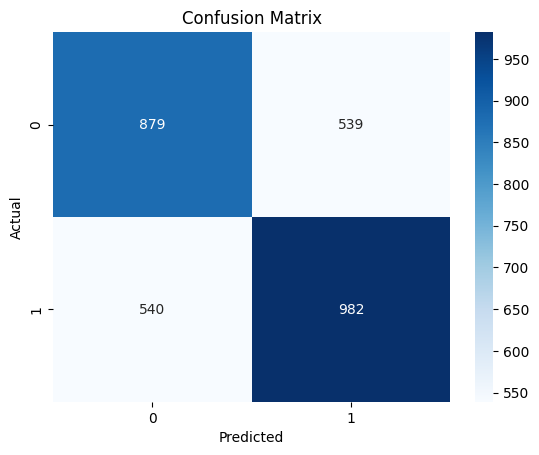

In [11]:
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

What we see:
- True Positives (bottom-right) and True Negatives (top-left) are strong — the model gets many predictions right.
- False Positives and False Negatives are roughly balanced, showing some uncertainty when players are closely ranked.
- The confusion matrix supports our accuracy score: the model is doing reasonably well but has room to grow.


## 📈 Probability Calibration Plot

A well-calibrated model outputs probabilities that match reality.
For example, if we predict a 70% chance of winning, the player should win about 70% of those matches.

This plot compares predicted probabilities to actual outcomes across decile bins.


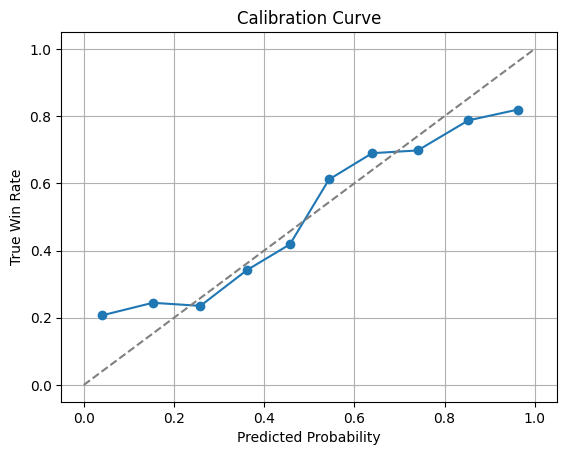

In [16]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_valid, y_pred_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted Probability")
plt.ylabel("True Win Rate")
plt.title("Calibration Curve")
plt.grid(True)
plt.show()

 What we see:
 - The model generally tracks well with the diagonal line — this means its predicted win probabilities mostly match actual outcomes.
 - It underestimates win probability in the 0.5–0.8 range (points below the line) and slightly overestimates at the highest end.
 - Overall, the model is moderately well-calibrated — good for a single-feature baseline. Adding richer features may help smooth the calibration curve.

## ✅ Summary

This model uses just one feature — `rank_diff` — to predict whether Player A wins a tennis match. It's deliberately simple, to help us isolate the predictive power of ATP rankings alone.

### 🔢 Key Metrics:
- **Accuracy: 63.3%** → well above random guessing (50%), showing that rank alone is a useful signal
 - **Log Loss: 0.664** → indicates that the model’s probability estimates are reasonably calibrated, though there’s room to improve
 - **ROC AUC: 0.666** → suggests moderate ability to rank likely winners above likely losers
 
 ### 💡 Interpretation:
This baseline confirms that **rankings capture meaningful performance differences** — but not all. Upsets still happen, and there's variation that rank alone can't explain.
 
 This gives us a clean benchmark. In our next models, we'll incrementally add:
 - Contextual factors like surface
 - Player-specific attributes (e.g. age, handedness)
 - Historical stats (e.g. recent form, head-to-head)
 
 Our goal: **see how much each type of information improves prediction beyond rank alone.**
 This simple model uses just one feature — `rank_diff` — and already performs above chance.
 
 - Accuracy shows how often we're right
 - Log loss and ROC AUC show how well our probabilities are calibrated
 
 We'll use this as our baseline to compare against future models that include surface, player history, and more.
